# Install

In [ ]:
!pip install pycaret --quiet
!pip install catboost --quiet
!pip install category_encoders --quiet

# Import & Options

In [ ]:
import warnings
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GroupKFold, cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
warnings.filterwarnings("ignore")

# Utils

In [ ]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False).sample(frac=1, replace=False).reset_index(drop=True)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

# Get data

In [ ]:
datasets = get_data(verbose=False)

In [ ]:
X, y, num_features, cat_features = get_dataset("bank")

In [ ]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,21,student,single,secondary,no,164,no,no,cellular,19,feb,78,5,-1,0,unknown
1,36,technician,married,secondary,no,366,no,yes,cellular,22,aug,136,6,-1,0,unknown
2,45,blue-collar,married,secondary,no,196,yes,no,cellular,2,feb,91,1,-1,0,unknown
3,27,student,single,secondary,no,274,no,no,cellular,27,may,283,1,-1,0,unknown
4,29,services,married,secondary,no,376,no,yes,telephone,28,jan,49,3,183,4,failure


In [ ]:
X["month"].value_counts()[["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]]

jan     1403
feb     2649
mar      477
apr     2932
may    13766
jun     5341
jul     6895
aug     6247
sep      579
oct      738
nov     3970
dec      214
Name: month, dtype: int64

In [ ]:
_X = X[X["month"] != "feb"]

for i, (train_index, test_index) in enumerate(GroupKFold(n_splits=5).split(X=_X, groups=_X["month"])):
    print(f"Fold {i+1}:", ", ".join(_X.iloc[test_index]["month"].unique().tolist()))

Fold 1: may
Fold 2: jul, mar
Fold 3: aug, oct
Fold 4: jan, jun, sep
Fold 5: apr, nov, dec


In [ ]:
model = XGBClassifier()

cross_val_score(estimator=model, X=X, y=y)

# Simulation configuration

In [ ]:
grouping_feature = "month"

groups = X[grouping_feature].value_counts().sort_values(key=lambda x: np.abs(x-5000)).index[:6].tolist()

split_map = {
    "cross-validation": "KFold(shuffle=True).split(X=X_learn)",
    "group k-fold": "GroupKFold().split(X=X_learn, groups=X_learn[grouping_feature])"
}

model_map = {
    "randomforest": Pipeline((("catboost_encoder", CatBoostEncoder()), ("randomforest", RandomForestClassifier()))),
    "xgboost": Pipeline((("catboost_encoder", CatBoostEncoder()), ("xgboost", XGBClassifier()))),
    "lightgbm": Pipeline((("catboost_encoder", CatBoostEncoder()), ("lgbm", LGBMClassifier(verbose=-1))))
}

In [ ]:
results = {
    group: {
        model_name: {
            split_name: {"ap_train": [], "ap_valid": [], "ap_learn": [], "ap_test": []
                } for split_name in list(split_map.keys())+["production"]
            } for model_name in model_map.keys()
        } for group in groups
}

# Simulation

In [ ]:
%%time

for group in groups:

    print(f"{group} in progress...")

    X_learn = X.loc[X[grouping_feature]!=group,:]
    y_learn = y.loc[X[grouping_feature]!=group]
    X_test = X.loc[X[grouping_feature]==group,:]
    y_test = y.loc[X[grouping_feature]==group]

    for model_name, model in model_map.items():

        # production model
        model_fit = model.fit(X_learn, y_learn)
        results[group][model_name]["production"]["ap_learn"].append(average_precision_score(y_learn, model_fit.predict_proba(X_learn)[:,1]))
        results[group][model_name]["production"]["ap_test"].append(average_precision_score(y_test, model_fit.predict_proba(X_test)[:,1]))

        for split_name, split_str in split_map.items():

            for index_train, index_valid in eval(split_str):

                # validation models
                model_fit = model.fit(X_learn.iloc[index_train,:], y_learn.iloc[index_train])
                results[group][model_name][split_name]["ap_train"].append(average_precision_score(y_learn.iloc[index_train], model_fit.predict_proba(X_learn.iloc[index_train,:])[:,1]))
                results[group][model_name][split_name]["ap_valid"].append(average_precision_score(y_learn.iloc[index_valid], model_fit.predict_proba(X_learn.iloc[index_valid,:])[:,1]))

jun in progress...
nov in progress...
aug in progress...
jul in progress...
apr in progress...
feb in progress...
CPU times: user 23min 47s, sys: 2.56 s, total: 23min 50s
Wall time: 23min 15s


# Results

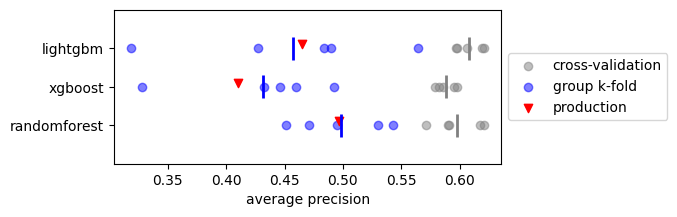

In [ ]:
fig, ax = plt.subplots(figsize=(5,2))

group = "feb"

for enum, model_name in enumerate(model_map.keys()):
    ax.scatter(results[group][model_name]["cross-validation"]["ap_valid"], [enum]*5, color="grey", alpha=.5, label="cross-validation" if enum==0 else None)
    ax.scatter(results[group][model_name]["group k-fold"]["ap_valid"], [enum]*5, color="blue", alpha=.5, label="group k-fold" if enum==0 else None)
    ax.vlines(np.mean(results[group][model_name]["cross-validation"]["ap_valid"]), enum-.3, enum+.3, lw=2, color="grey")
    ax.vlines(np.mean(results[group][model_name]["group k-fold"]["ap_valid"]), enum-.3, enum+.3, lw=2, color="blue")
    ax.scatter(results[group][model_name]["production"]["ap_test"], [enum+.1], color="red", marker="v", label="production" if enum==0 else None)

ax.set_xlabel("average precision")
ax.set_yticks(range(len(model_map.keys())))
ax.set_yticklabels(model_map.keys())
ax.set_ylim(-1, len(model_map.keys()))

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.savefig(f"cv_vs_kfold_vs_prod_{group}.png", dpi=200, bbox_inches="tight")

In [ ]:
out = pd.DataFrame()

for group in groups:
    for model_name in model_map.keys():
        for split_name in split_map.keys():

            ap_valid = results[group][model_name][split_name]["ap_valid"]
            ap_test = results[group][model_name]["production"]["ap_test"]
            ap_valid_mean = np.mean(ap_valid)
            ap_valid_std = np.std(ap_valid)
            ap_test_mean = np.mean(ap_test)
            distance_from_production = ap_valid_mean - ap_test_mean
            std_from_production = abs(distance_from_production) / ap_valid_std

            out = out.append({
                "group": group,
                "model_name": model_name,
                "split_name": split_name,
                "ap_valid_mean": ap_valid_mean,
                "ap_test_mean": ap_test_mean,
                "distance_from_production": distance_from_production,
                "std_from_production": std_from_production
            }, ignore_index=True)

In [ ]:
pd.crosstab(out["group"], out["split_name"], out["distance_from_production"], aggfunc=np.mean).round(2)

split_name,cross-validation,group k-fold
group,,
apr,0.12,0.01
aug,0.07,-0.07
feb,0.14,0.01
jul,0.04,-0.10
jun,0.29,0.17
nov,0.13,0.01


In [ ]:
pd.crosstab(out["group"], out["split_name"], out["std_from_production"], aggfunc=np.mean).round(2)

split_name,cross-validation,group k-fold
group,,
apr,8.81,0.25
aug,3.98,1.05
feb,14.73,0.18
jul,2.81,1.56
jun,18.04,3.55
nov,8.79,0.27
